## SVC Classifier
The model predicts the severity of the landslide (or if there will even be one) within the next 2 days, based on weather data from the past 5 days.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.utils import shuffle
import pickle

In [2]:
# df = pd.read_csv("full_dataset_v1.csv")
df = pd.read_csv("dataset.csv")
len(df)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


17808

In [3]:
df['severity'].value_counts()

medium          5594
small           2612
unknown          834
large            679
...              359
very_large       102
Medium            72
Unknown           19
Large             17
Small             10
catastrophic       4
landslide          2
Very_large         1
Very...large       1
Name: severity, dtype: int64

In [4]:
# filter by severity. na is for non-landslide data
# df = df[df['severity'].isin(["medium", "small", "large", "very_large", "na"])]
# Remove -1 slopes
# df = df.loc[~(df.slope == -1)]

In [5]:
df['severity'].value_counts()
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
print(len(df))

17808


In [6]:
X = df.copy()
y = X.landslide
columns=[]
for i in range(9, 4, -1):
    columns.append('humidity' + str(i))
    columns.append('ARI' + str(i))
columns.append('slope')
columns.append('forest2')
columns.append('osm')
X = X[columns]
X

,humidity9,ARI9,humidity8,ARI8,humidity7,ARI7,humidity6,ARI6,humidity5,ARI5,slope,forest2,osm
0,94,0.089812,95,0.161204,95,0.245696,98,0.137235,95,0.051337,2.175,1,6320
1,48,0.006780,78,0.004483,83,0.003187,59,0.001350,44,0.264586,4.531,1,1581
2,82,1.422149,70,0.567757,57,0.309602,65,0.195297,74,0.134498,0.000,0,312
3,59,0.028348,99,0.000000,100,0.000000,94,0.000000,99,1.322929,23.029,1,1756
4,94,0.188113,91,0.091490,92,0.036379,85,0.022342,88,0.013933,14.242,1,3178
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17803,93,0.369029,93,1.300976,99,1.846464,98,2.444062,99,1.720421,20.239,1,2608
17804,97,0.408730,93,0.353438,94,0.131711,92,0.071530,92,2.874520,4.707,1,16954
17805,52,0.164043,82,1.436848,68,0.414428,79,0.146992,77,0.082683,14.312,0,1051
17806,86,0.488186,83,0.355041,87,0.346975,89,0.184828,84,0.033683,4.264,1,143


## Scaling

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## PCA

In [8]:
from sklearn.decomposition import PCA
pca = PCA(0.9)

principalComponents = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([0.43341633, 0.18762311, 0.08219791, 0.07672617, 0.05631004,
       0.05179036, 0.03585658])

In [9]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [10]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', verbose = True)

In [11]:
svclassifier.fit(X_train, y_train)

[LibSVM]

SVC(verbose=True)

In [12]:
from sklearn.metrics import accuracy_score
pred = svclassifier.predict(X_test)
print("ACCURACY:" ,accuracy_score(pred, y_test))

ACCURACY: 0.862436833239753


## Testing gamma and c

In [45]:
from sklearn.metrics import accuracy_score
C_range =[1, 10, 100]
gamma_range = [0.1, 1, 10, 100]
for c in C_range:
    for g in gamma_range:
        svc2 = SVC(kernel='rbf', gamma=g,C=c, verbose = True)
        svc2.fit(X_train, y_train)
        print(c, g, ":",accuracy_score(y_test, svc2.predict(X_test)))

[LibSVM]1 0.1 : 0.6749545178896301
[LibSVM]1 1 : 0.6734384475439661
[LibSVM]1 10 : 0.6431170406306853
[LibSVM]1 100 : 0.47604608853850816
[LibSVM]10 0.1 : 0.6761673741661614
[LibSVM]10 1 : 0.6613098847786537
[LibSVM]10 10 : 0.6228016979987872
[LibSVM]10 100 : 0.47847180109157067
[LibSVM]100 0.1 : 0.6749545178896301
[LibSVM]100 1 : 0.6367495451788963
[LibSVM]100 10 : 0.6103699211643421
[LibSVM]100 100 : 0.47847180109157067


In [46]:
svc2 = SVC(kernel='rbf', gamma=0.1,C=10, verbose = True)
svc2.fit(X_train, y_train)
accuracy_score(y_test, svc2.predict(X_test))

[LibSVM]

0.6761673741661614

In [13]:
pred = svc2.predict(X_test)
print("ACCURACY:" ,accuracy_score(pred, y_test))

ACCURACY: 0.862436833239753


## Confusion Matrix

In [14]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_test, pred)
array

array([[1217,  273],
       [ 217, 1855]])

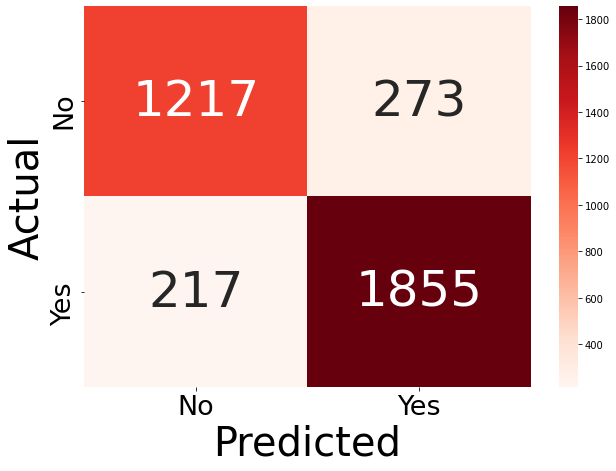

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
binary=True
if binary:
    df_cm = pd.DataFrame(array, index = [i for i in ["No", "Yes"]],
                    columns = [i for i in ["No", "Yes"]])
else:
    df_cm = pd.DataFrame(array, index = [i for i in ["None", "Small", "Medium", "Large", "Very Large"]],
                  columns = [i for i in ["None", "Small", "Medium", "Large", "Very Large"]])

plt.figure(figsize = (10,7))

ax = sn.heatmap(df_cm, cmap="Reds", annot=True, annot_kws={"size":50}, fmt='g')
ax.tick_params(axis='both', which='major', labelsize=27)
plt.xlabel('Predicted', fontsize = 40) 
# plt.title("KNN Confusion Matrix", fontsize = 50)
plt.ylabel('Actual', fontsize = 40)
plt.savefig("SVC Matrix", bbox_inches="tight")

plt.show()